In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display


# 鑑黃大師 (pytorch)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import efficientnet

trident 0.5.6
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:7.1.2.
Pytorch version:1.5.1+cu101.


![Alt text](../images/porndetector.jpg)

![Alt text](../images/pornclass.jpg)

In [3]:
dataset=load_examples_data('nsfw')
dataset.image_transform_funcs=[
    random_adjust_gamma(gamma=(0.8,1.2)),
    #隨機調整圖片明暗gamma 0.6~1.4之間
    random_adjust_contrast(scale=(0.8, 1.2)),
    #隨機調整圖片對比度
    random_adjust_hue(),
    #隨機調整色相
    add_noise(intensity=np.random.choice(np.arange(0.001,0.1,0.0005))),
    #隨機加入噪音
    random_center_crop(224,224,scale=(0.9,1.1)),
    normalize(0, 255),  
    normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

#數據集的圖片處理流程image_transform_funcs為標準imagenet標準化
#加上隨機調整色相random_adjust_hue以及隨機等比例縮放中心裁切random_center_crop

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
training images: 10001  test images:5746
Mapping class_names  in en-us   success, total 5 class names added.
Mapping class_names  in zh-tw   success, total 5 class names added.
Mapping class_names  in zh-cn   success, total 5 class names added.


![Alt text](../images/nsfw_data.jpg)

![Alt text](../images/EfficientNet.jpg)

In [4]:
#獲取EfficientNet-B0預訓練模型
#將全連接層長度改為5
effb0=efficientnet.EfficientNetB0(include_top=True,
             pretrained=True,
             input_shape=(3,224,224),
             classes=5)

#只開放全連接層以及最後一組Efficient Block開放學習
effb0.model.trainable=False
effb0.model.fc.trainable=True
effb0.model.block7a.trainable=True


model file is already existing, donnot need download again.
4013953 parameters have set untrainable
6405 parameters have set trainable
717232 parameters have set trainable


In [5]:
#召回率
def recall(output,target):
    input_tensor=output.clone().detach()
    target_tensor=target.clone().detach()
    input_tensor=argmax(input_tensor,1).squeeze() #將預測結果透過argmax，產生類別的判斷
    input_tensor=input_tensor.eq(3).float() #檢查那些預測結果是3(色情圖片)
    target_tensor=target_tensor.eq(3).float() #檢查那些答案是3(色情圖片)
    return (input_tensor*target_tensor).sum()/max(target_tensor.sum(),1)
#input_tensor*target_tensor兩個相乘結果為1，則表示實際是色情圖片且正確被預測
#除以所有的色情圖片總數target_tensor.sum()就可以獲得召回率

In [6]:
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_epoch_start(self, training_context):
        if training_context['current_epoch']==2:
            training_context['current_model'].block6d.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==10:
            training_context['current_model'].block6c.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==15:
            training_context['current_model'].block6b.trainable=True #透過training_context切換模型指定層的trainable狀態
    

In [7]:
effb0=effb0\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_loss(F1ScoreLoss(beta=0.5),name='f1_score')\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(recall,name='recall')\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')\
    .with_model_save_path('Models/effb0_v2.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-4,warmup=0)\
    .with_callbacks(CustomCallback())

#指定優化器(使用Ranger)
#設定損失函數(交叉熵)
#設定評估函數(正確率與召回率)
#設定l2正則化
#設定min_max_norm權重約束
#指定模型存檔位置
#指定學習速率調整機制


effb0.summary()
#檢視模型結構

CrossEntropyLoss( output, target) -> CrossEntropyLoss 
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
f1_score( output, target) -> f1_score 
f1_score( output, target) -> f1_score 
accuracy( output, target) -> accuracy 
recall( output, target) -> recall 
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
conv2d_1                                 [-1, 32, 112, 112]    [32, 3, 3, 3]                  864       21663488.0  
batch_norm_1                             [-1, 32, 112, 112]    [32]                 [32]      64        1191680.0   
stem                                     [-1, 32, 112, 112]                                   0         0.0         
block1a_dwconv                           [-1, 32, 112, 112]                                   0         0.0         
batch_norm_2            

In [8]:
#設定學習計畫
#指定資料提供者
#跑10個epoach
#minibatch_size為16
#每10個批次列印一次訓練進度
#每100個批次顯示一次loss_metric_curve
#每10個批次存檔一次
plan=TrainingPlan()\
    .add_training_item(effb0)\
    .with_data_loader(dataset)\
    .repeat_epochs(15)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .save_model_scheduling(10,unit='batch')

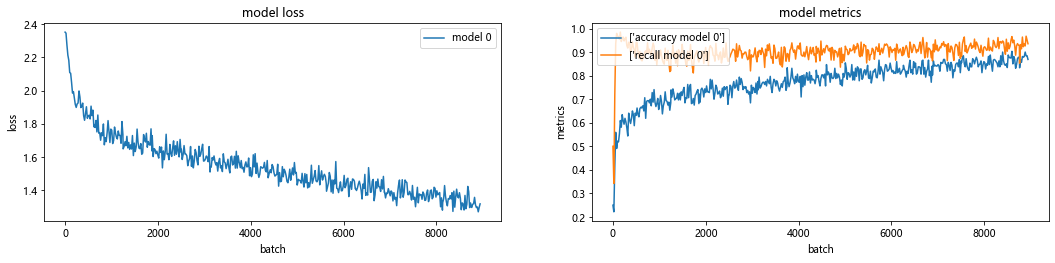

model 0      Step: 11s923ms | Loss: 1.313   | accuracy: 85.938% ,recall: 92.994%  | learning rate: 1.000e-03 | epoch: 14  ( 200/626 )
model 0      Step: 11s480ms | Loss: 1.273   | accuracy: 87.187% ,recall: 92.348%  | learning rate: 1.000e-03 | epoch: 14  ( 220/626 )
model 0      Step: 11s463ms | Loss: 1.315   | accuracy: 87.500% ,recall: 93.334%  | learning rate: 1.000e-03 | epoch: 14  ( 240/626 )
model 0      Step: 11s468ms | Loss: 1.286   | accuracy: 88.750% ,recall: 94.045%  | learning rate: 1.000e-03 | epoch: 14  ( 260/626 )
model 0      Step: 11s547ms | Loss: 1.319   | accuracy: 88.750% ,recall: 94.357%  | learning rate: 1.000e-03 | epoch: 14  ( 280/626 )


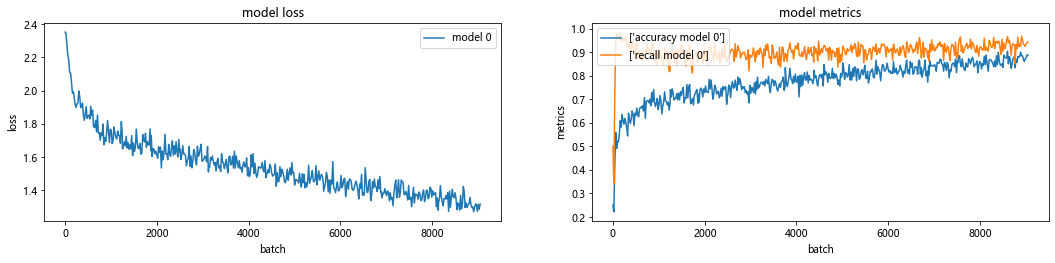

model 0      Step: 12s9ms   | Loss: 1.347   | accuracy: 84.375% ,recall: 92.601%  | learning rate: 1.000e-03 | epoch: 14  ( 300/626 )
model 0      Step: 11s458ms | Loss: 1.272   | accuracy: 90.000% ,recall: 93.942%  | learning rate: 1.000e-03 | epoch: 14  ( 320/626 )
model 0      Step: 11s446ms | Loss: 1.278   | accuracy: 89.688% ,recall: 96.210%  | learning rate: 1.000e-03 | epoch: 14  ( 340/626 )
model 0      Step: 11s377ms | Loss: 1.278   | accuracy: 90.312% ,recall: 94.730%  | learning rate: 1.000e-03 | epoch: 14  ( 360/626 )
model 0      Step: 11s497ms | Loss: 1.303   | accuracy: 88.125% ,recall: 92.970%  | learning rate: 1.000e-03 | epoch: 14  ( 380/626 )


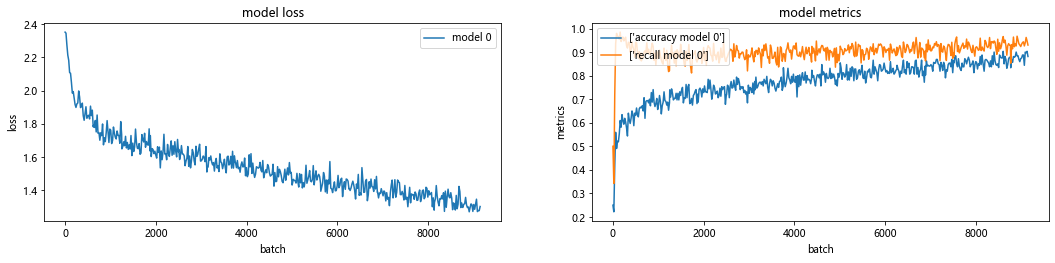

model 0      Step: 11s993ms | Loss: 1.263   | accuracy: 89.688% ,recall: 92.918%  | learning rate: 1.000e-03 | epoch: 14  ( 400/626 )
model 0      Step: 11s462ms | Loss: 1.318   | accuracy: 87.813% ,recall: 93.872%  | learning rate: 1.000e-03 | epoch: 14  ( 420/626 )
model 0      Step: 11s499ms | Loss: 1.331   | accuracy: 87.187% ,recall: 92.139%  | learning rate: 1.000e-03 | epoch: 14  ( 440/626 )
model 0      Step: 11s434ms | Loss: 1.311   | accuracy: 87.187% ,recall: 92.335%  | learning rate: 1.000e-03 | epoch: 14  ( 460/626 )
model 0      Step: 11s448ms | Loss: 1.328   | accuracy: 85.625% ,recall: 91.163%  | learning rate: 1.000e-03 | epoch: 14  ( 480/626 )


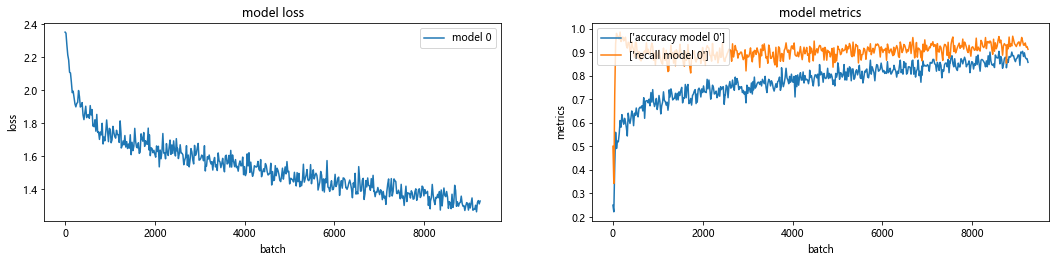

model 0      Step: 12s41ms  | Loss: 1.287   | accuracy: 89.375% ,recall: 97.061%  | learning rate: 1.000e-03 | epoch: 14  ( 500/626 )
model 0      Step: 11s401ms | Loss: 1.327   | accuracy: 85.938% ,recall: 88.797%  | learning rate: 1.000e-03 | epoch: 14  ( 520/626 )
model 0      Step: 11s481ms | Loss: 1.325   | accuracy: 86.875% ,recall: 93.898%  | learning rate: 1.000e-03 | epoch: 14  ( 540/626 )
model 0      Step: 11s516ms | Loss: 1.405   | accuracy: 87.500% ,recall: 92.216%  | learning rate: 1.000e-03 | epoch: 14  ( 560/626 )
model 0      Step: 11s461ms | Loss: 1.337   | accuracy: 87.500% ,recall: 93.534%  | learning rate: 1.000e-03 | epoch: 14  ( 580/626 )


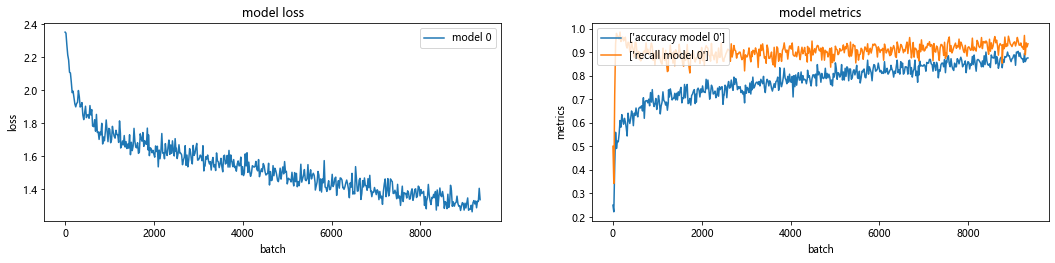

model 0      Step: 12s86ms  | Loss: 1.326   | accuracy: 87.500% ,recall: 89.712%  | learning rate: 1.000e-03 | epoch: 14  ( 600/626 )
model 0      Step: 11s412ms | Loss: 1.288   | accuracy: 87.813% ,recall: 91.132%  | learning rate: 1.000e-03 | epoch: 14  ( 620/626 )
model 0: out-of-sample evaluation:  accuracy: 62.500% ,recall: 80.000% 


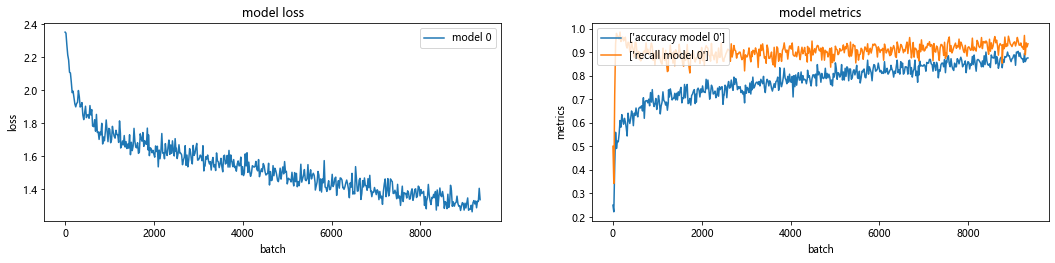

In [9]:
#執行訓練
plan.start_now()

In [10]:
effb0.class_names=dataset.class_names['zh-tw']

{ 繪畫: (0, 0.48996142), 色情: (3, 0.26206645), 中性: (2, 0.21308868) }


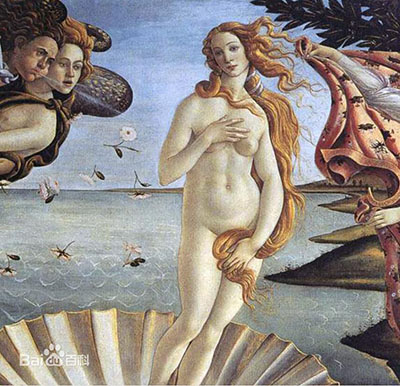

In [11]:
img=read_image('../images/venus.jpg')
print(effb0.infer_single_image('../images/venus.jpg',3))
img

{ 色情: (3, 0.62253433), 性感: (4, 0.37397838), 中性: (2, 0.0034293097) }


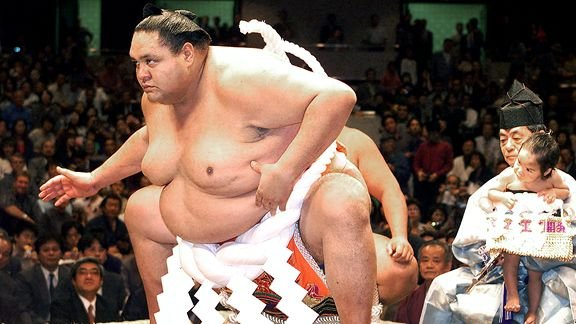

In [12]:
img=read_image('../images/sumo.jpg')
print(effb0.infer_single_image('../images/sumo.jpg',3))
img

{ 性感: (4, 0.94775575), 色情: (3, 0.030983608), 色情漫畫: (1, 0.01692443) }


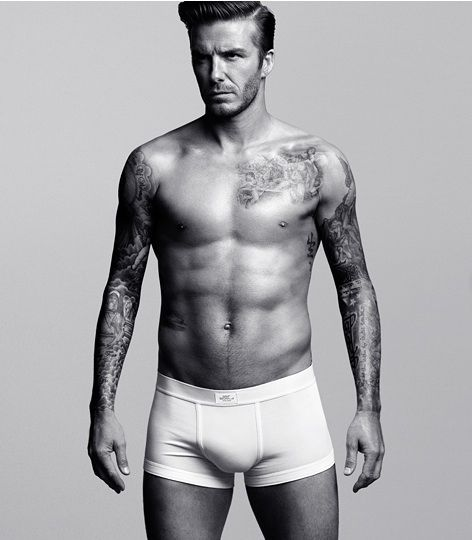

In [13]:
img=read_image('../images/beckham.jpg')
print(effb0.infer_single_image('../images/beckham.jpg',3))
img

{ 性感: (4, 0.4884106), 色情: (3, 0.46866888), 色情漫畫: (1, 0.022059552) }


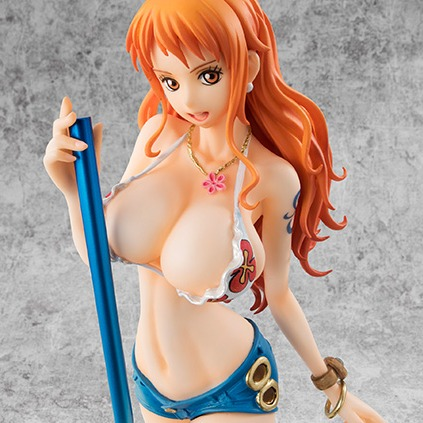

In [14]:
img=read_image('../images/nami.jpg')
print(effb0.infer_single_image('../images/nami.jpg',3))
img

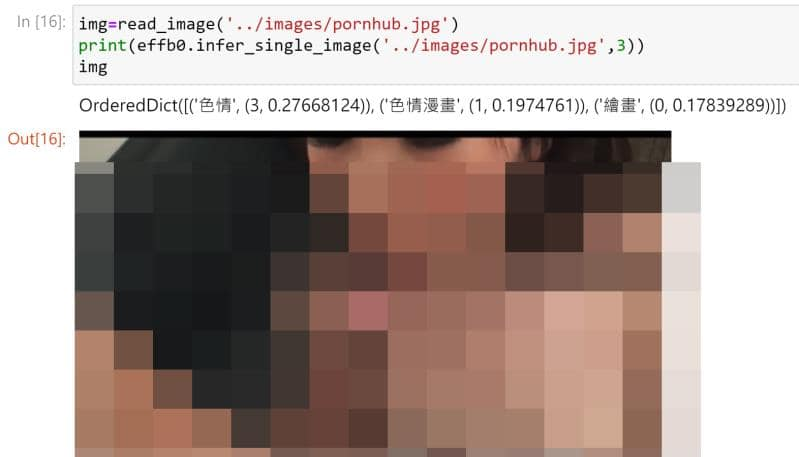

In [15]:
img=read_image('../images/pornhub.jpg')
img